In [9]:
import pandas as pd 
smallest_index = 515
# get clean plant data
df = pd.read_excel("ultratech_data_clean.xlsx")
df = df.iloc[0:,0:19]
df = df.drop(["A", "B", "a", "group","resnorm"], 1)
df = df.dropna()
df = df[((df.Q_f>100))]
df = df[((df.Q_p < 100))]
df = df[((df.Q_p > 50))]
df = df[((df.index < 6000))]
df["C_f"] = df["C_f"]*0.64
df["C_p"] = df["C_p"]*0.64
df["Cond. At ERT to RWST [AIT - 005] [µS/cm]"] = df["Cond. At ERT to RWST [AIT - 005] [µS/cm]"]*.64
df["SP"] = df["C_p"]/df["C_f"]*100
df.head()

,Datetime,Q_f,Q_p,FT at ERT to RWST [FT - 105] [m³/h],T_f,C_p,C_f,Cond. At ERT to RWST [AIT - 005] [µS/cm],pH_p,pH_f,ORP_f,PH of ERT To RWST [AIT - 013] [-],dp,P_f,SP
515,2018-05-27 19:00:00,261.0,82.0,173.0,30.39,337.28,38888.96,52812.80,6.98,7.74,-10.53,6.39,0.8,58.30,0.867290
516,2018-05-27 20:00:00,261.0,82.0,173.0,30.39,337.28,38888.96,52812.80,6.98,7.74,-10.53,6.39,0.8,58.30,0.867290
517,2018-05-27 21:00:00,261.0,83.0,174.0,30.40,339.20,38924.16,52768.00,6.89,7.71,-8.68,6.29,0.8,58.28,0.871438
518,2018-05-27 22:00:00,261.0,83.0,174.0,30.40,339.20,38924.16,52768.00,6.89,7.71,-8.68,6.29,0.8,58.28,0.871438
519,2018-05-27 23:00:00,261.0,83.0,176.0,30.50,340.48,38999.04,52851.84,6.83,7.68,-6.81,6.27,0.8,58.40,0.873047


In [10]:
import numpy as np
from posm import osmotic_pressure_TX
class ReverseNormalize():
    def __init__(self):
        #layout the factors that I want for the functions
        pass
    def set_reference(self,Q_p, Q_f, Temp, Conc_f, Conc_p, P_f, P_p, dp):      
        self.Temp = Temp
        self.Qp = Q_p
        self.Qf = Q_f
        self.Cf = Conc_f
        self.Cp = Conc_p
        self.Pf = P_f
        self.Pp = P_p
        self.dp = dp
        self.Tcf = self.TCF(Temp)
    
    def TCF(self, T):
        temps = []
        try:
            for t in T:
                if t<25:
                    temps.append(np.exp(3020*(1/(298)-1/(273+t))))
                else:
                    temps.append(np.exp(2640*(1/(298)-1/(273+t))))
        except:
            if T<25:
                temps = np.exp(3020*(1/298-1/(273+T)))
            else:
                temps = np.exp(2640*(1/298-1/(273+T)))
        return temps
    def TMP(self, Pf, Pp, dp, Cf, Cp, Temp):
        OB_f = osmotic_pressure_TX(Cf, Temp)
        OB_p = osmotic_pressure_TX(Cp, Temp)
        TMP = Pf-(dp/2+Pp+OB_f-OB_p)
        return TMP
    
    def SPnorm(self, Qp, TCF, Cf):
        return Qp/self.Qp/TCF/self.Tcf*Cf/self.Cf
    
    def DPnorm(self,Qf, Qp):
        return (2*self.Qf-self.Qp)/(2*Qf-Qp)
    
    def Concentrate(self,Cf, Pf, Cp, Qp, Qf):
        Cfc = -Cf*np.log(1-Qp/Qf)/(Qp/Qf)
        R = (Cf-Cp)/Cf
        return Cfc/Cf*Pf-(1-R)
    
    def SPB(self, SP, TCF, Qp):
        return SP/TCF*Qp
    
    def Flow(self,Qp, Qf, Temp, Cf, Cp, Pf, Pp, dp):
        TCF = self.TCF(Temp)
        TMP = self.TMP(Pf, Pp, dp, Cf, Cp, Temp)
        AS = Qp/TMP
        TCFref = self.Tcf
        TMPref = self.TMP(self.Pf, self.Pp, self.dp, self.Cf, self.Cp, self.Temp)
        ASref = self.Qp/TMPref
        Qrefpress = TMPref*AS
        QNM = TMP*ASref
        Qtemp = TMP*AS
        return Qrefpress, QNM, Qtemp
    
    def SP(self, Cf, Cp, Qf, Qp, T):
        SP = Cp/Cf*100
        self.Sp = self.Cp/self.Cf*100
        TCF =  self.TCF(T)
        TCFref = self.TCF(self.Temp)
        B = self.SPB(SP, TCF, Qp)
        Bref = self.SPB(self.Sp,TCFref,self.Qp)
        SPtemp = B*TCFref/Qp
        SPNM = Bref*(TCF/Qp)
        return SP, SPtemp, SPNM
    
    def DP(self,Qp, Qf, T):
        TCF = self.TCF(T)
        DPNM = self.dp/self.DPnorm(Qf, Qp)
        return DPNM

In [11]:
RV = ReverseNormalize()
RV.set_reference(df.at[smallest_index,"Q_p"],df.at[smallest_index,"Q_f"],df.at[smallest_index,"T_f"],df.at[smallest_index,"C_f"],df.at[smallest_index,"C_p"],
                    df.at[smallest_index,"P_f"],1,df.at[smallest_index,"dp"])

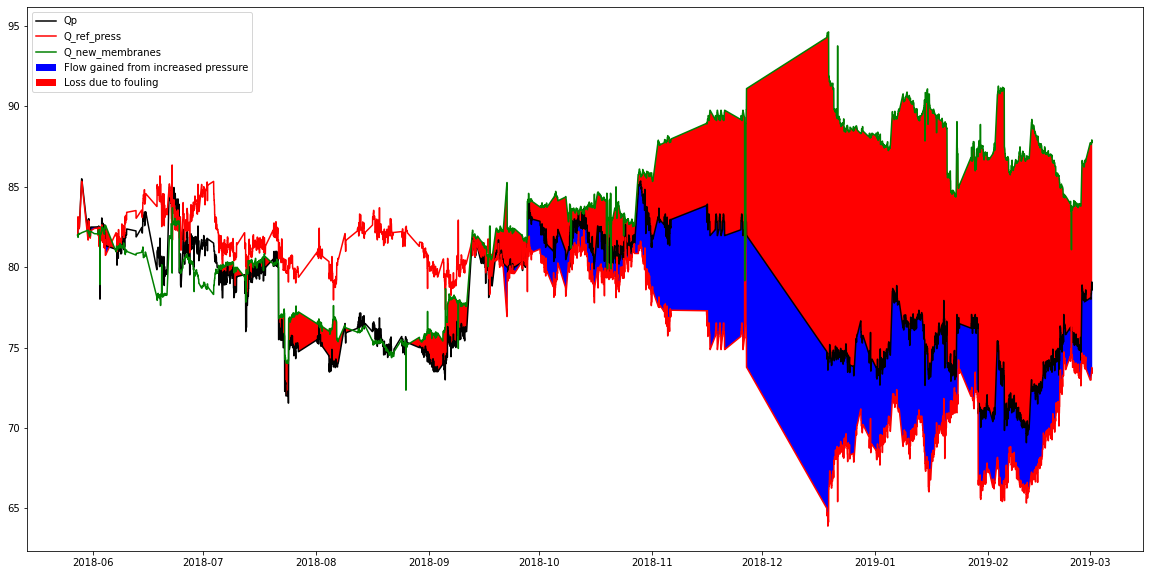

In [12]:
import matplotlib.pyplot as plt

Qp, QNM, Qt = RV.Flow(df["Q_p"],df["Q_f"], df["T_f"],df["C_f"],df["C_p"],df["P_f"],1,df["dp"])
figure = plt.figure(figsize=(20,10))
plt.plot(df.Datetime, df.Q_p, c="black", label="Qp")
plt.plot(df.Datetime, Qp, c="r", label="Q_ref_press")
plt.plot(df.Datetime, QNM, c="g", label="Q_new_membranes")
plt.fill_between(df.Datetime, df.Q_p, Qp, where=df.Q_p>=Qp, facecolor="blue", interpolate=True, label="Flow gained from increased pressure" )
plt.fill_between(df.Datetime, df.Q_p, QNM, where=df.Q_p<=QNM, facecolor="red", interpolate=True, label="Loss due to fouling" )
plt.legend()
plt.show()

Text(0, 0.5, 'Salt Passage')

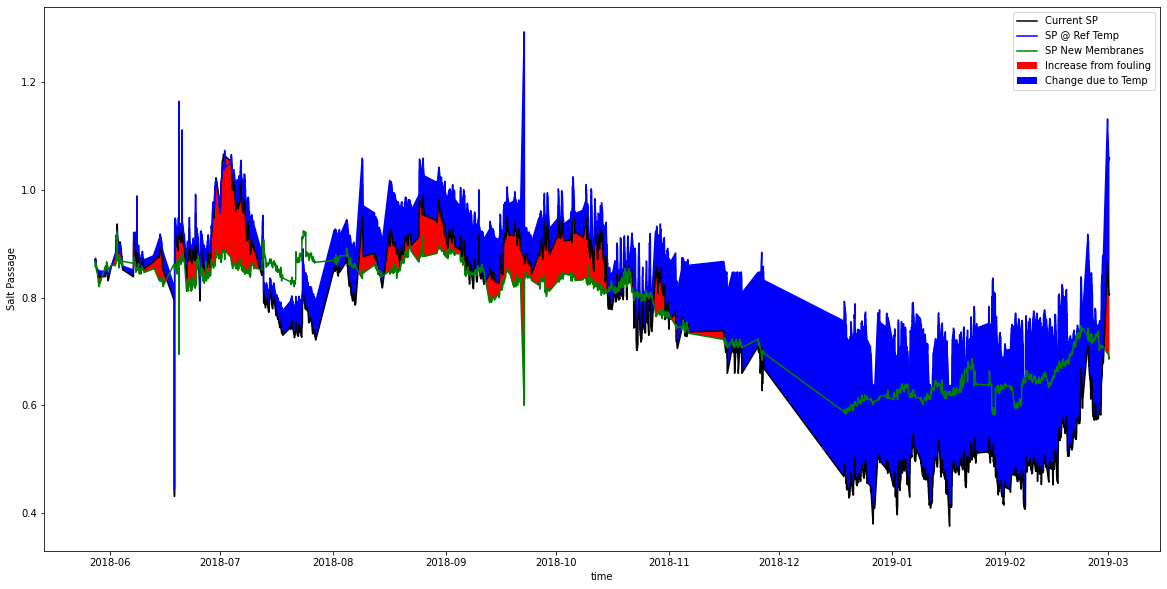

In [13]:
SP, SPtemp, SPNM = RV.SP(df["C_f"], df["C_p"], df["Q_f"], df["Q_p"], df["T_f"])
figure = plt.figure(figsize=(20,10))
plt.plot(df.Datetime, SP, c="black", label="Current SP")
plt.plot(df.Datetime, SPtemp, c="b",label="SP @ Ref Temp" )
plt.plot(df.Datetime, SPNM, c="g", label="SP New Membranes" )
plt.fill_between(df.Datetime, SP, SPNM, where=SP>=SPNM, facecolor="red", interpolate=True, label="Increase from fouling" )
plt.fill_between(df.Datetime, SP, SPtemp, where=SP<=SPtemp, facecolor="blue", interpolate=True, label="Change due to Temp" )
plt.legend()
plt.xlabel("time")
plt.ylabel("Salt Passage")


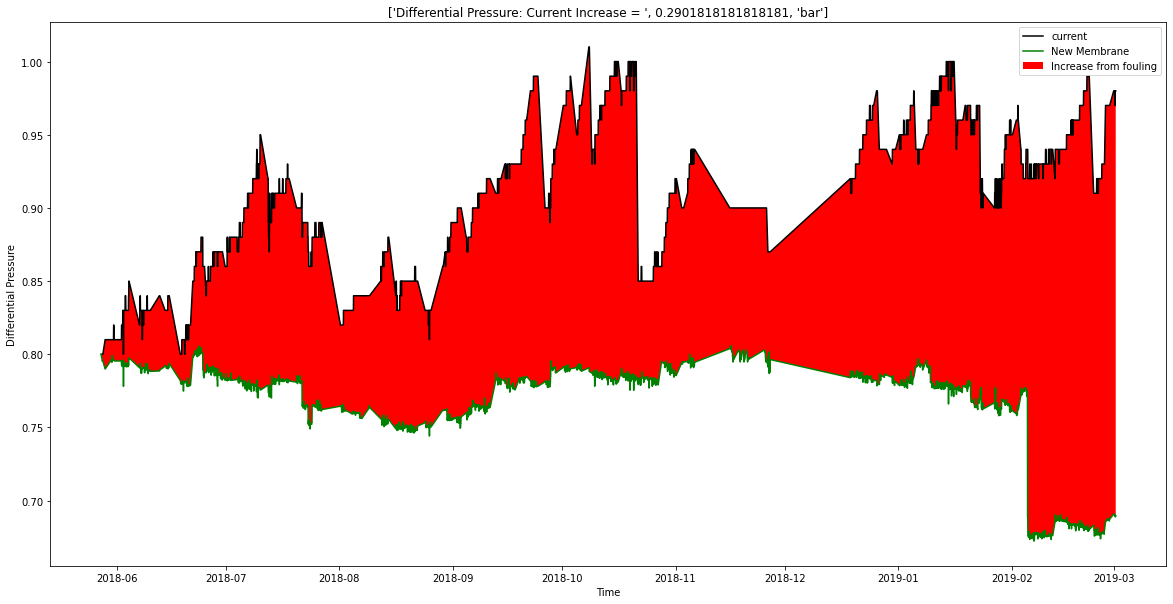

In [14]:
DPNM = RV.DP(df.Q_p, df.Q_f, df.T_f)
figure = plt.figure(figsize=(20,10))
plt.plot(df.Datetime, df.dp, c="black", label="current")
plt.plot(df.Datetime, DPNM, c="g", label="New Membrane")
plt.fill_between(df.Datetime, df.dp, DPNM, where=df.dp>=DPNM, facecolor="red", interpolate=True, label="Increase from fouling" )
plt.ylabel("Differential Pressure")
plt.xlabel("Time")
plt.title(["Differential Pressure: Current Increase = ", df.dp.iloc[-1]-DPNM.iloc[-1], "bar"])
plt.legend()
plt.show()


0.717752457